In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score

In [2]:


file_paths = ['/content/btc_1h.csv','/content/btc_2h.csv','/content/btc_3m.csv','/content/btc_4h.csv','/content/btc_5m.csv','/content/btc_6h.csv','/content/btc_15m.csv','/content/btc_30m.csv']


dfs = [pd.read_csv(file, parse_dates=['datetime'], index_col='datetime', error_bad_lines=False) for file in file_paths]
df = pd.concat(dfs)
df=df.reset_index()
print(df.head())
print(df.shape)

# Convert datetime column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce',format='%Y-%m-%d %H:%M:%S')
df = df.dropna(subset=['datetime'])




<ipython-input-2-e653ee98ec23>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs = [pd.read_csv(file, parse_dates=['datetime'], index_col='datetime', error_bad_lines=False) for file in file_paths]
Skipping line 16639: expected 6 fields, saw 11

<ipython-input-2-e653ee98ec23>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs = [pd.read_csv(file, parse_dates=['datetime'], index_col='datetime', error_bad_lines=False) for file in file_paths]
<ipython-input-2-e653ee98ec23>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs = [pd.read_csv(file, parse_dates=['datetime'], index_col='datetime', error_bad_lines=False) for file in file_paths]
<ipython-input-2-e653ee98ec23>:4: FutureWarning: The error_bad_line

              datetime      open      high       low     close      volume
0  2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199
1  2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06  383.697006
2  2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18  429.064572
3  2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03  420.087030
4  2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01  340.807329
(118872, 6)


In [3]:
# Drop records with bad datetime values
before_drop_count = len(df)
df = df.dropna(subset=['datetime'])
after_drop_count = len(df)
print(f"Records before dropping bad datetime values: {before_drop_count}")
print(f"Records after dropping bad datetime values: {after_drop_count}")



Records before dropping bad datetime values: 118871
Records after dropping bad datetime values: 118871


In [4]:
# Filter data between Jan 1, 2018, and Jan 31, 2022
start_date = '2018-01-01'
end_date = '2022-01-31'
df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]
df.set_index('datetime',inplace =True)
# Resample data to time intervals (adjust according to your choice)
time_interval = '3T'  # Example: 3 minutes
df_resampled = df.resample(time_interval).last().dropna()

# Display basic statistics and plot stock prices
print("\nBasic Statistics:")
print(df_resampled.describe())
print(len(df))


Basic Statistics:
               open          high           low         close         volume
count  62029.000000  62029.000000  62029.000000  62029.000000   62029.000000
mean   13262.152052  13351.708319  13164.176697  13262.189322    2615.717656
std    12423.007311  12549.256503  12280.839307  12421.039580    5792.601032
min        3.000000   3176.240000   3156.260000   3167.070000       0.000000
25%     7346.080000   7380.000000   7313.080000   7344.990000     140.573743
50%     9489.010000   9542.000000   9428.420000   9489.680000     503.601292
75%    11871.950000  11928.000000  11801.310000  11868.990000    1861.077480
max    68635.120000  69000.000000  68451.190000  68633.690000  162319.716490
118859


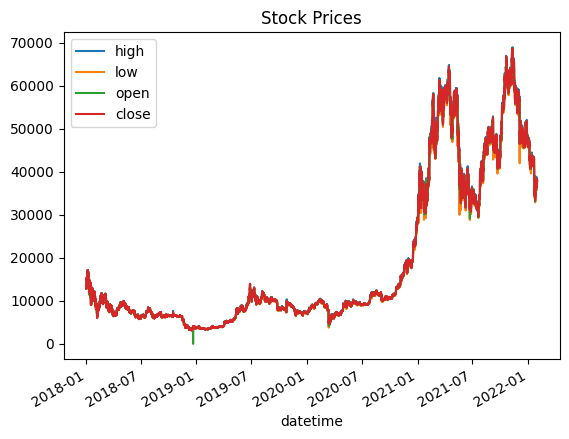

In [5]:
df_resampled[['high', 'low', 'open', 'close']].plot(title='Stock Prices')
plt.show()

In [6]:

print("\nBasic EDA:")
print("DataFrame Shape:", df_resampled.shape)
print("DataFrame Size:", df_resampled.size)
print("DataFrame Info:")
print(df_resampled.info())
print("DataFrame Head:")
print(df_resampled.head())




Basic EDA:
DataFrame Shape: (62029, 5)
DataFrame Size: 310145
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62029 entries, 2018-01-01 05:30:00 to 2022-01-30 23:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    62029 non-null  float64
 1   high    62029 non-null  float64
 2   low     62029 non-null  float64
 3   close   62029 non-null  float64
 4   volume  62029 non-null  float64
dtypes: float64(5)
memory usage: 2.8 MB
None
DataFrame Head:
                         open      high       low     close      volume
datetime                                                               
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13521.12  221.752443
2018-01-01 05:33:00  13600.00  13600.00  13501.01  13554.58   40.528679
2018-01-01 05:36:00  13568.00  13575.00  13501.01  13575.00   29.645987
2018-01-01 05:39:00  13554.58  13569.97  13400.01  13556.15   49.469536
2018-01-01 05:42:00  13515

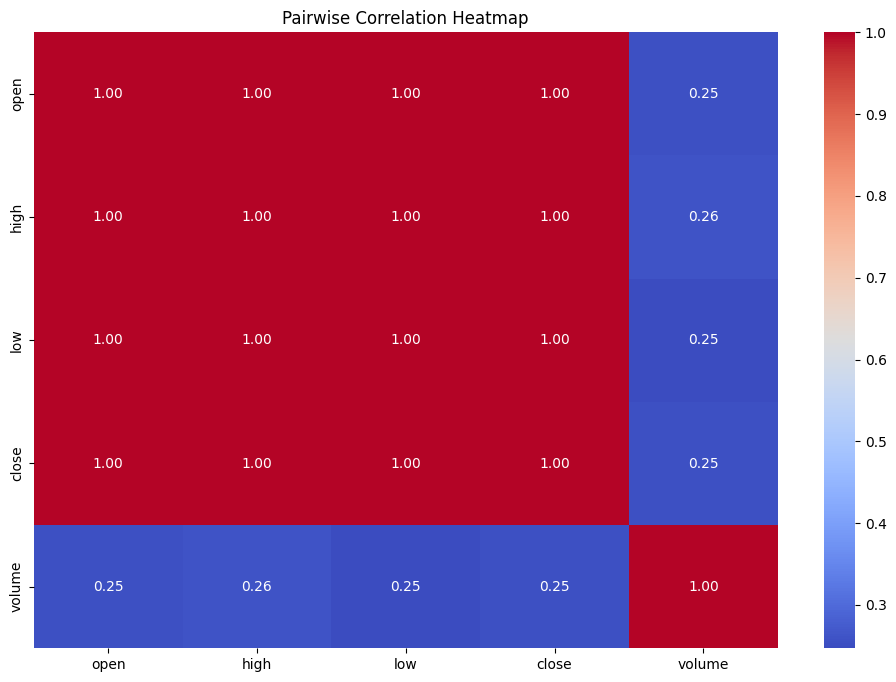

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Pairwise correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pairwise Correlation Heatmap")
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


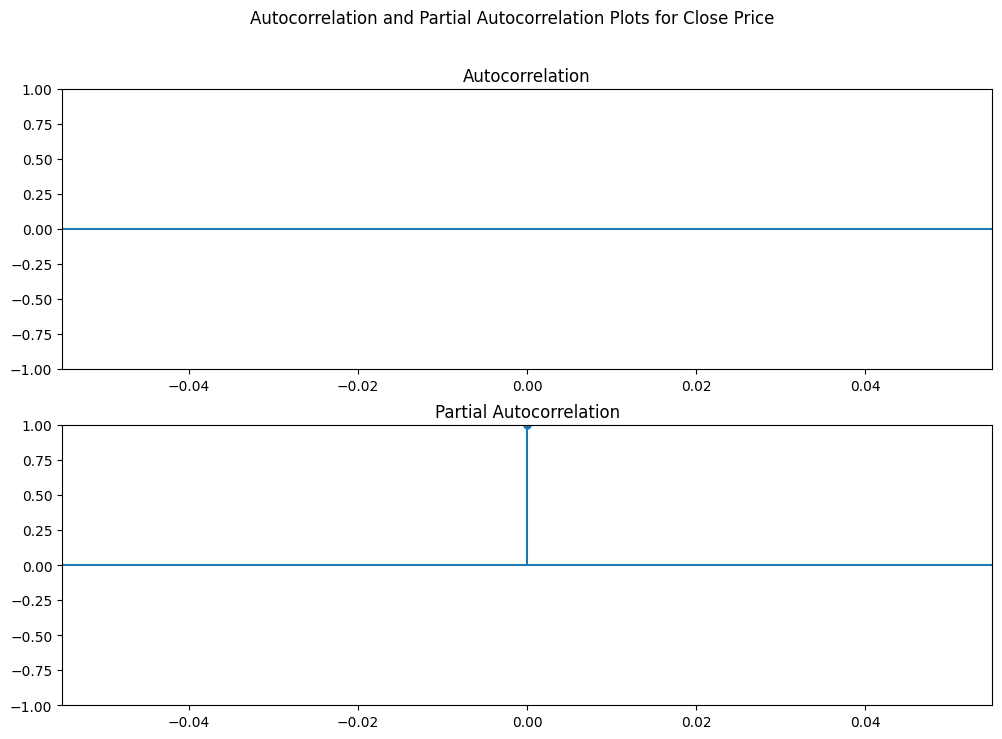

In [8]:
# Autocorrelation and Partial Autocorrelation plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['close'], lags=50, ax=ax1)
plot_pacf(df['close'], lags=50, ax=ax2)
plt.suptitle("Autocorrelation and Partial Autocorrelation Plots for Close Price")
plt.show()


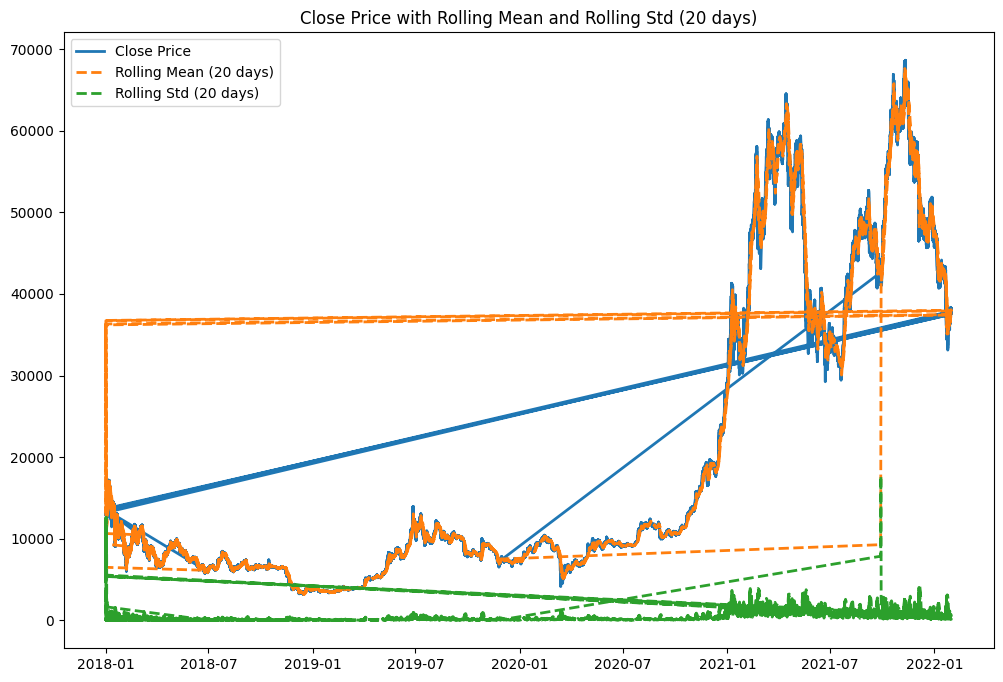

In [9]:
# Rolling statistics (e.g., rolling mean and rolling standard deviation)
window = 20  # Adjust the window size based on your preference
df['RollingMean'] = df['close'].rolling(window=window).mean()
df['RollingStd'] = df['close'].rolling(window=window).std()

plt.figure(figsize=(12, 8))
plt.plot(df['close'], label='Close Price', linewidth=2)
plt.plot(df['RollingMean'], label=f'Rolling Mean ({window} days)', linestyle='--', linewidth=2)
plt.plot(df['RollingStd'], label=f'Rolling Std ({window} days)', linestyle='--', linewidth=2)
plt.title(f'Close Price with Rolling Mean and Rolling Std ({window} days)')
plt.legend()
plt.show()

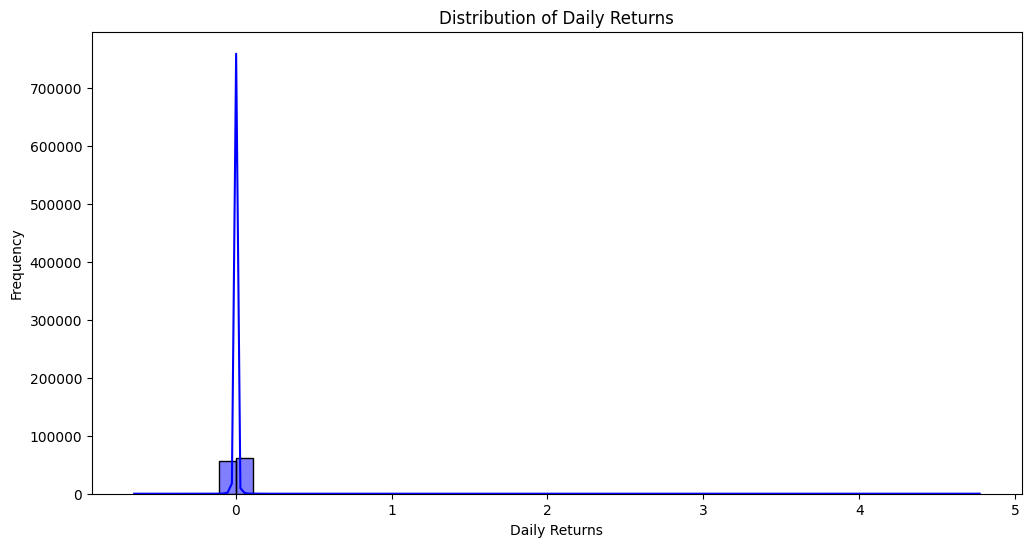

In [10]:
# Distribution of returns
returns = df['close'].pct_change().dropna()
plt.figure(figsize=(12, 6))
sns.histplot(returns, bins=50, kde=True, color='blue')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_resampled[['open', 'high', 'low', 'close', 'volume']])

#PCA for Dimensionality Reduction
pca = PCA()
pca_result = pca.fit_transform(scaled_features)

# Add PCA components to the DataFrame
for i in range(pca_result.shape[1]):
    df_resampled[f'PC{i+1}'] = pca_result[:, i]

# Print explained variance ratio
print("\nExplained Variance Ratio:")
print(np.cumsum(pca.explained_variance_ratio_))

# Initial Trading Rules (Example: Golden Cross and Death Cross)
df_resampled['Short_MA'] = df_resampled['close'].rolling(window=50).mean()
df_resampled['Long_MA'] = df_resampled['close'].rolling(window=200).mean()

# Signal for Golden Cross (Buy)
df_resampled['Signal'] = 0
df_resampled.loc[df_resampled['Short_MA'] > df_resampled['Long_MA'], 'Signal'] = 1

# Signal for Death Cross (Sell)
df_resampled.loc[df_resampled['Short_MA'] < df_resampled['Long_MA'], 'Signal'] = -1

# Display the DataFrame with added features
print("\nDataFrame with Added Features:")
print(df_resampled.head())


Explained Variance Ratio:
[0.82374834 0.99992611 0.99996604 0.99999485 1.        ]

DataFrame with Added Features:
                         open      high       low     close      volume  \
datetime                                                                  
2018-01-01 05:30:00  13715.65  13715.65  13400.01  13521.12  221.752443   
2018-01-01 05:33:00  13600.00  13600.00  13501.01  13554.58   40.528679   
2018-01-01 05:36:00  13568.00  13575.00  13501.01  13575.00   29.645987   
2018-01-01 05:39:00  13554.58  13569.97  13400.01  13556.15   49.469536   
2018-01-01 05:42:00  13515.26  13568.66  13473.47  13556.15   23.260966   

                          PC1       PC2       PC3       PC4       PC5  \
datetime                                                                
2018-01-01 05:30:00 -0.027502 -0.415619  0.015855  0.005253  0.002360   
2018-01-01 05:33:00 -0.037244 -0.445734  0.002510 -0.001480  0.002153   
2018-01-01 05:36:00 -0.039040 -0.447313 -0.000675 -0.001210  0.003

In [12]:
from statsmodels.tsa.stattools import acf

# Part 4: Autocorrelation Length and Plots

# Autocorrelation Length Function
def autocorrelation_length(series):
    acf_values = acf(series)
    return np.argmax(np.abs(acf_values) < 1/np.exp(1))

# Example of Usage
autocorr_length_close = autocorrelation_length(df_resampled['close'])
print(f"\nAutocorrelation Length for 'close' column: {autocorr_length_close}")




Autocorrelation Length for 'close' column: 0


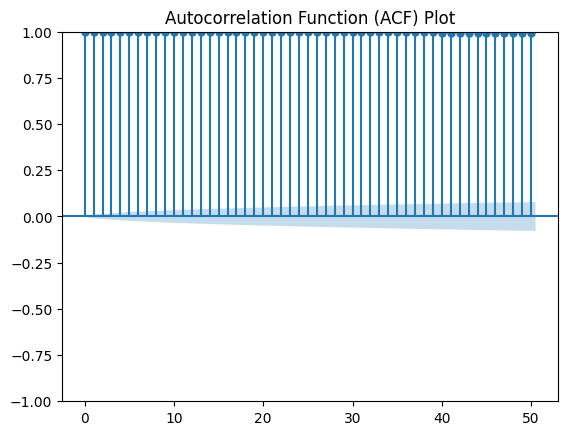

In [13]:
# Plot Autocorrelation Function (ACF)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_resampled['close'], lags=50)
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

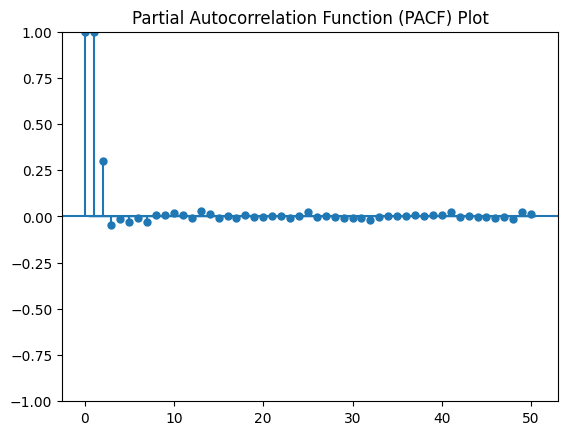

In [14]:

# Plot Partial Autocorrelation Function (PACF)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_resampled['close'], lags=50)
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()

In [15]:
# Function to calculate autocorrelation length
def autocorrelation_length(series):
    acf_values = acf(series)
    return np.argmax(np.abs(acf_values) < 1/np.exp(1))



# Assuming 'target' is the target column for classification
df_resampled['target'] = df_resampled['Signal'].shift(-1)
df_resampled.dropna(inplace=True)

# Feature columns
features = ['open', 'high', 'low', 'close', 'volume', 'PC1', 'PC2', 'PC3']

# Calculate autocorrelation length for 'close' column
autocorr_length_close = autocorrelation_length(df_resampled['close'])

In [16]:
# Function to calculate autocorrelations for different lags
def calculate_autocorrelations(series, max_lag):
    autocorrelations = [acf(series.shift(lag).dropna())[0] for lag in range(1, max_lag + 1)]
    return autocorrelations

# Calculate autocorrelations for the 'close' column
max_lag = 50  # Adjust as needed
autocorrelations = calculate_autocorrelations(df_resampled['close'], max_lag)

# Add autocorrelation values to the DataFrame
for lag, autocorr_value in enumerate(autocorrelations, start=1):
    df_resampled[f'Autocorrelation_Lag_{lag}'] = autocorr_value

# Now you can use the autocorrelation columns in your trading strategy code
autocorr_length_close = autocorrelation_length(df_resampled['close'])
df_resampled['Mean_Reversion_Signal'] = 0

# Define threshold for mean reversion
autocorrelation_threshold = 0.5  # Adjust according to your data

# Generate mean reversion signals
lag_to_use = autocorr_length_close if autocorr_length_close > 0 else 1
df_resampled.loc[df_resampled['Autocorrelation_Lag_' + str(lag_to_use)] < autocorrelation_threshold, 'Mean_Reversion_Signal'] = -1

# Print summary of mean reversion signals
print("\nSummary of Mean Reversion Signals:")
print(df_resampled['Mean_Reversion_Signal'].value_counts())


Summary of Mean Reversion Signals:
0    61829
Name: Mean_Reversion_Signal, dtype: int64


In [17]:
# Assuming 'target' is the target column for classification
df_resampled['target'] = df_resampled['Signal'].shift(-1)
df_resampled.dropna(inplace=True)

# Feature columns
features = ['open', 'high', 'low', 'close', 'volume', 'PC1', 'PC2', 'PC3', 'Mean_Reversion_Signal']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_resampled[features], df_resampled['target'], test_size=0.2, random_state=42)

# Model fitting with autocorrelation length
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [18]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print model accuracy and classification report
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_rep)

Model Accuracy: 68.04%

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.68      0.66      0.67      6110
         1.0       0.68      0.70      0.69      6256

    accuracy                           0.68     12366
   macro avg       0.68      0.68      0.68     12366
weighted avg       0.68      0.68      0.68     12366



In [19]:
# ROC AUC Score (binary classification)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"\nROC AUC Score")
print(roc_auc)


ROC AUC Score
0.7570410834404211


In [20]:
# Trading Strategy: Doubling Investment after Loss
loss_condition = df_resampled['Signal'] == -1
df_resampled['Investment_Doubling'] = 1.0  # Initial investment amount, can be adjusted
df_resampled.loc[loss_condition, 'Investment_Doubling'] *= 2

# Trading Strategy: Moving Average Crossover
df_resampled['Short_MA'] = df_resampled['close'].rolling(window=50).mean()
df_resampled['Long_MA'] = df_resampled['close'].rolling(window=200).mean()
df_resampled['Signal_MA'] = 0
df_resampled.loc[df_resampled['Short_MA'] > df_resampled['Long_MA'], 'Signal_MA'] = 1
df_resampled.loc[df_resampled['Short_MA'] < df_resampled['Long_MA'], 'Signal_MA'] = -1

# Trading Strategy: Buy and Hold
df_resampled['Signal_BuyHold'] = 1  # Buy and hold throughout the period

# Calculate transaction costs for each strategy
transaction_cost_percentage = 0.0015  # Adjustable
for strategy in ['Investment_Doubling', 'Signal_MA', 'Signal_BuyHold']:
    df_resampled[f'Transaction_Costs_{strategy}'] = df_resampled[strategy].shift(-1) * df_resampled['close'].pct_change() * transaction_cost_percentage

# Calculate profit and net profit for each strategy
for strategy in ['Investment_Doubling', 'Signal_MA', 'Signal_BuyHold']:
    df_resampled[f'Profit_{strategy}'] = df_resampled[strategy].shift(-1) * df_resampled['close'].pct_change()
    df_resampled[f'Net_Profit_{strategy}'] = df_resampled[f'Profit_{strategy}'] - df_resampled[f'Transaction_Costs_{strategy}']

# Calculate cumulative return for each strategy
for strategy in ['Investment_Doubling', 'Signal_MA', 'Signal_BuyHold']:
    df_resampled[f'Cumulative_Return_{strategy}'] = (1 + df_resampled[f'Net_Profit_{strategy}']).cumprod()

# Print performance metrics for each strategy
for strategy in ['Investment_Doubling', 'Signal_MA', 'Signal_BuyHold']:
    total_trades = df_resampled[strategy].diff().ne(0).sum()
    winning_trades = (df_resampled[f'Profit_{strategy}'] > 0).sum()
    losing_trades = (df_resampled[f'Profit_{strategy}'] < 0).sum()
    win_rate = winning_trades / total_trades * 100 if total_trades > 0 else 0
    max_drawdown = ((1 - df_resampled[f'Cumulative_Return_{strategy}'] / df_resampled[f'Cumulative_Return_{strategy}'].cummax()).max()) * 100
    average_winning_trade = df_resampled[df_resampled[f'Profit_{strategy}'] > 0][f'Profit_{strategy}'].mean()
    average_losing_trade = df_resampled[df_resampled[f'Profit_{strategy}'] < 0][f'Profit_{strategy}'].mean()

    print(f"\nPerformance Metrics for {strategy}:")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades}")
    print(f"Losing Trades: {losing_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Average Winning Trade: {average_winning_trade:.2f}")
    print(f"Average Losing Trade: {average_losing_trade:.2f}")






Performance Metrics for Investment_Doubling:
Total Trades: 391
Winning Trades: 24324
Losing Trades: 23974
Win Rate: 6220.97%
Max Drawdown: 99.56%
Average Winning Trade: 0.01
Average Losing Trade: -0.01

Performance Metrics for Signal_MA:
Total Trades: 391
Winning Trades: 24171
Losing Trades: 23969
Win Rate: 6181.84%
Max Drawdown: 57.40%
Average Winning Trade: 0.01
Average Losing Trade: -0.01

Performance Metrics for Signal_BuyHold:
Total Trades: 1
Winning Trades: 24324
Losing Trades: 23974
Win Rate: 2432400.00%
Max Drawdown: 81.49%
Average Winning Trade: 0.01
Average Losing Trade: -0.01


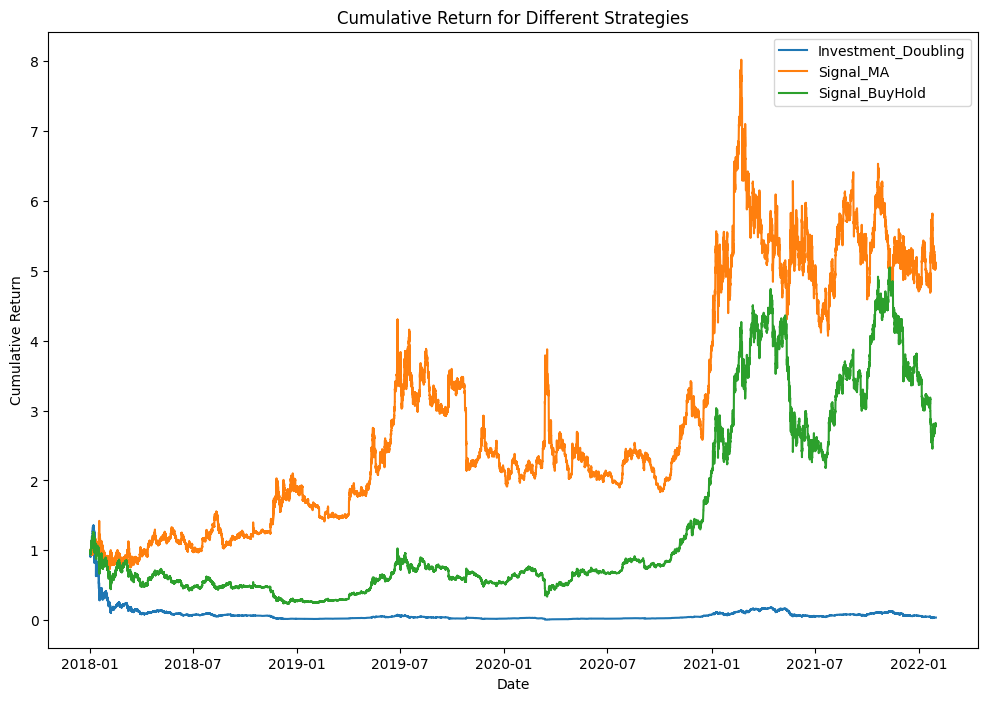

In [21]:
# Plot Cumulative Return for each strategy
plt.figure(figsize=(12, 8))
for strategy in ['Investment_Doubling', 'Signal_MA', 'Signal_BuyHold']:
    plt.plot(df_resampled.index, df_resampled[f'Cumulative_Return_{strategy}'], label=strategy)

plt.title('Cumulative Return for Different Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [45]:
# Initialize columns
df_resampled['Profit']=((df_resampled['close']-df_resampled['open'])/df_resampled['open'])*100
df_resampled['Transaction_Costs'] = 0.0
df_resampled['Gross_Profit'] = 0.0
df_resampled['Net_Profit'] = 0.0
df_resampled['Gross_Loss'] = 0.0
df_resampled['Max_Drawdown'] = 0.0
df_resampled['Buy_Hold_Return'] = 0.0
df_resampled['Total_Closed_Trades'] = 0
df_resampled['Number_Winning_Trades'] = 0
df_resampled['Number_Losing_Trades'] = 0
df_resampled['Average_Winning_Trade'] = 0.0
df_resampled['Average_Losing_Trade'] = 0.0
df_resampled['Largest_Winning_Trade'] = 0.0
df_resampled['Largest_Losing_Trade'] = 0.0
df_resampled['Sharpe_Ratio'] = 0.0
df_resampled['Sortino_Ratio'] = 0.0
df_resampled['Average_Holding_Duration'] = 0.0
df_resampled['Max_Dip'] = 0.0
df_resampled['Average_Dip'] = 0.0
risk=0.02
target_return=df_resampled['Profit'].max()
average_return=df_resampled['Profit'].mean()
risk_free_return=average_return-risk
portfolio_std_dev=df_resampled['Profit'].std()
sharpe_ratio=risk_free_return/portfolio_std_dev
downside_returns=df_resampled[df_resampled['Profit']<target_return]['Profit']
downside_std_Dev=downside_returns.std()
sortino_ratio=(average_return-target_return)/downside_std_Dev
buy_dates = df_resampled.index[df_resampled['Signal'] == 1]
sell_dates = df_resampled.index[df_resampled['Signal'] == -1]

trade_entries = df_resampled[df_resampled['Signal'] != 0]

# Calculate the holding duration for each trade
trade_entries['Holding_Duration'] = trade_entries.index.to_series().diff().dt.days

# Calculate the average holding duration
average_holding_duration = trade_entries['Holding_Duration'].mean()



# Capture trade-related information
df_resampled['Transaction_Costs'] = df_resampled['Signal'].diff() * df_resampled['close'] * 0.0015
df_resampled['Trade_Profit'] = df_resampled['Profit'] - df_resampled['Transaction_Costs']
df_resampled['Cumulative_Return'] = (1 + df_resampled['Trade_Profit']).cumprod()
df_resampled['Running_Max_Return'] = df_resampled['Cumulative_Return'].cummax()

# Calculate metrics
df_resampled['Gross_Profit'] = df_resampled['Trade_Profit'][df_resampled['Trade_Profit'] > 0].sum()
df_resampled['Net_Profit'] = df_resampled['Trade_Profit'].sum()
df_resampled['Gross_Loss'] = -df_resampled['Trade_Profit'][df_resampled['Trade_Profit'] < 0].sum()
df_resampled['Max_Drawdown'] = (1 - df_resampled['Cumulative_Return'] / df_resampled['Running_Max_Return']).max()
df_resampled['Total_Closed_Trades'] = df_resampled['Signal'].diff().ne(0).sum()
df_resampled['Number_Winning_Trades'] = (df_resampled['Trade_Profit'] > 0).sum()
df_resampled['Number_Losing_Trades'] = (df_resampled['Trade_Profit'] < 0).sum()
df_resampled['Average_Winning_Trade'] = df_resampled['Trade_Profit'][df_resampled['Trade_Profit'] > 0].mean()
df_resampled['Average_Losing_Trade'] = -df_resampled['Trade_Profit'][df_resampled['Trade_Profit'] < 0].mean()
df_resampled['Largest_Winning_Trade'] = df_resampled['Trade_Profit'].max()
df_resampled['Largest_Losing_Trade'] = -df_resampled['Trade_Profit'].min()


df_resampled['Max_Dip'] = df_resampled['Cumulative_Return'].min() - 1  # Assuming starting with capital of 1
df_resampled['Average_Dip'] = df_resampled['Cumulative_Return'].mean() - 1  # Assuming starting with capital of 1

# Assuming we start with an investment of $10,000
initial_investment = 10000
df_resampled['Buy_Hold_Return'] = (df_resampled['close'] / df_resampled['close'].iloc[0]) * initial_investment

# Print the calculated metrics
print("\nPerformance Metrics:")
print(f"1. Gross Profit:",df_resampled['Gross_Profit'])
print(f"2. Net Profit:", df_resampled['Net_Profit'])
print(f"3. Gross Loss:", df_resampled['Gross_Loss'])
print(f"4. Max Drawdown:", df_resampled['Max_Drawdown'] * 100)
print(f"5. Buy and Hold Return of BTC: {df_resampled['Buy_Hold_Return'].iloc[-1] * 100:.2f}%")
print("6. Sharpe Ratio:" ,sharpe_ratio)
print(f"7. Sortino Ratio: {sortino_ratio}")
print(f"8. Total Closed Trades: {df_resampled['Total_Closed_Trades']}")
print(f"9. Number of Winning Trades: {df_resampled['Number_Winning_Trades']}")
print(f"10. Number of Losing Trades: {df_resampled['Number_Losing_Trades']}")
print(f"11. Average Winning Trade (in USDT):",df_resampled['Average_Winning_Trade'])
print(f"12. Average Losing Trade (in USDT):",df_resampled['Average_Losing_Trade'])
print(f"13. Largest Winning Trade (in USDT):",df_resampled['Largest_Winning_Trade'])
print(f"14. Largest Losing Trade (in USDT):",df_resampled['Largest_Losing_Trade'])
print(f"15. Average Holding Duration per Trade: ",average_holding_duration,"days")
print(f"16. Max Dip:",df_resampled['Max_Dip'] * 100)
print(f"17. Average Dip:",df_resampled['Average_Dip'] * 100)


Performance Metrics:
1. Gross Profit: datetime
2018-01-01 15:27:00    157220.456743
2018-01-01 15:30:00    157220.456743
2018-01-01 15:33:00    157220.456743
2018-01-01 15:36:00    157220.456743
2018-01-01 15:39:00    157220.456743
                           ...      
2022-01-30 17:30:00    157220.456743
2022-01-30 18:30:00    157220.456743
2022-01-30 19:30:00    157220.456743
2022-01-30 20:30:00    157220.456743
2022-01-30 21:30:00    157220.456743
Name: Gross_Profit, Length: 61828, dtype: float64
2. Net Profit: datetime
2018-01-01 15:27:00    134096.426209
2018-01-01 15:30:00    134096.426209
2018-01-01 15:33:00    134096.426209
2018-01-01 15:36:00    134096.426209
2018-01-01 15:39:00    134096.426209
                           ...      
2022-01-30 17:30:00    134096.426209
2022-01-30 18:30:00    134096.426209
2022-01-30 19:30:00    134096.426209
2022-01-30 20:30:00    134096.426209
2022-01-30 21:30:00    134096.426209
Name: Net_Profit, Length: 61828, dtype: float64
3. Gross Loss: d